# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


## Постановка задачи
Вы - NLP-инженер новостной аналитической платформы. Ваша система одновременно извлекает сущности из новостных текстов (NER, токен-уровень) и определяет набор прикладных событий и отношений в документе (CLS, документ-уровень). Это позволяет автоматически помечать важные факты в новостях (персоны, организации, даты) и формировать теги и инцидентные фильтры для быстрого поиска и аналитики.

Но есть проблема: текущий пайплайн раздельно выполняет NER и классификацию событий. В результате признаки дублируются, а вычислительные ресурсы используются неэффективно. 

Вы предположили, что совместное обучение (multi-task) повысит качество NER и/или стабильность детекции событий. Чтобы проверить гипотезу, вам предстоит построить компактный воспроизводимый эксперимент, который:

- **реализует объединённую encoder-модель, которая решает задачи NER и классификации событий**;
- делает качественные и количественные **выводы о взаимном влиянии задач**.

## Критерии успеха
- **token_f1 ≥ 0.5 и cls_micro_f1 ≥ 0.8**

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных

Публичный датасет NEREL в формате JSONL: train, dev, test. Этот датасет содержит тексты, сущности (строки с офсетами) и отношения/события, его можно скачать на huggingface:


- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/train.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/dev.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/test.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/ent_types.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/rel_types.jsonl


**Целевой признак:**
- NER (классфикация токенов): train.jsonl\text -> train.jsonl\entities -> **ent_types.jsonl\type**
- Multi-label классификация текстов: train.jsonl\text -> **rel_types.jsonl\type**

## Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



## Инициализация

### Импорт библиотек

In [2]:
import re
from collections import Counter
import os
import urllib.request
import json
import pandas as pd
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification
from bertviz import head_view
import torch
import torch.nn as nn
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, precision_score, recall_score
from seqeval.metrics import f1_score as seqeval_f1, classification_report as seqeval_report


/home/user/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Установка главных параметров

In [ ]:
ENCODER_NAME = "cointegrated/rubert-tiny2"
#ENCODER_NAME = "sentence-transformers/all-MiniLM-L6-v2"
TOKENIZER_MAX_LEN = 512
RELATIONS_MAX_LEN = 30 # TOP отношений
EPOCHS_MAX = 3000
LEARNING_RATE = 5e-5
TEXT_LR = 1e-5
DROPOUT = 0.1
WEIGHT_DECAY = 1e-4
SCHEDULER_T_MAX = 10
SCHEDULER_ETA_MIN = 1e-6
BATCH_SIZE = 32
TARGET_TOKEN_MACRO_F1 = 0.5
TARGET_CLS_MICRO_F1 = 0.8

## Загрузка данных

In [4]:
files = ["data/train.jsonl", "data/test.jsonl"]
if not os.path.exists ("data"):
    os.mkdir("data")
    
if not os.path.exists (files[0]):
    for f in files:
        urllib.request.urlretrieve( \
            f"https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/{f}", f)

In [5]:
def load_jsonl (path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

In [6]:
train_dataset = load_jsonl("data/train.jsonl")
test_dataset = load_jsonl("data/test.jsonl")

## 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [7]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}

In [8]:
train_dataset[:3]

[{'id': 0,
  'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба от

In [9]:
def make_event_list(records, K=30):
    entities, relations = dict(), dict()
    text_lens, entities_lens = [], []

    for i, news in enumerate(records):
        for j, entity in enumerate(records[i]['entities']):
            parsed = parse_entity_line(entity)
            t = parsed['type']
            entities[t] = entities.get(t, 0) + 1
        for j, relation in enumerate(records[i]['relations']):
            parsed = parse_relation_line(relation)
            r = parsed['type']
            relations[r] = relations.get(r, 0) + 1
        text_lens.append ( len(records[i]['text'].split()) )
        entities_lens.append ( len(records[i]['entities']) )

    top_entities = sorted(entities.items(), key=lambda x: x[1], reverse=True)
    top_relations = sorted(relations.items(), key=lambda x: x[1], reverse=True)

    print (f"Всего уникальных сущностей {len(top_entities)}")
    print (f"Всего уникальных отношений {len(top_relations)}")
    top_entities = top_entities[:K]
    top_relations = top_relations[:K]
    
    return top_entities, top_relations, text_lens, entities_lens

records = train_dataset
top30_entities, top30_relations, text_lens, entities_per_doc = \
    make_event_list(records, RELATIONS_MAX_LEN)

top30_relations_list = [x[0] for x in top30_relations]

Всего уникальных сущностей 29
Всего уникальных отношений 49


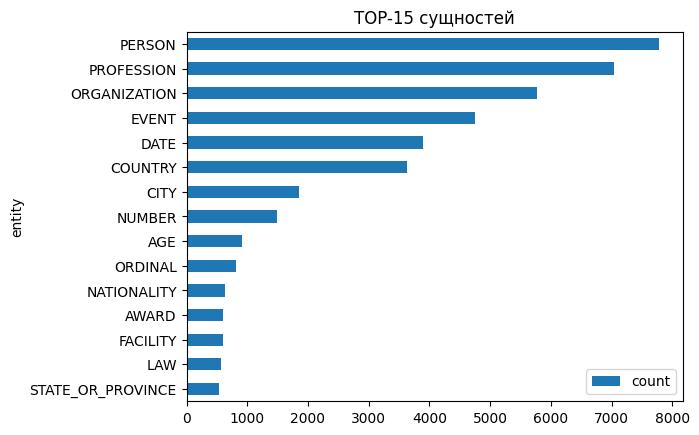

In [10]:
top_entities_df = pd.DataFrame(top30_entities[:15], columns=['entity', 'count'])
top_entities_df = top_entities_df.set_index('entity')
ax = top_entities_df.plot.barh(title="TOP-15 сущностей")
ax.invert_yaxis()

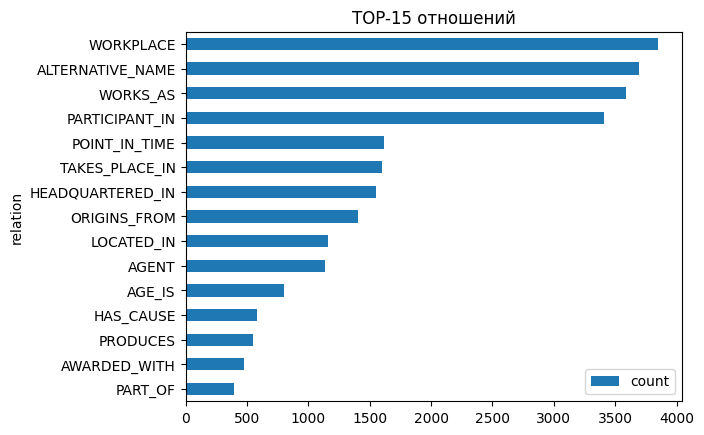

In [11]:
top_relations_df = pd.DataFrame(top30_relations[:15], columns=['relation', 'count'])
top_relations_df = top_relations_df.set_index('relation')
ax = top_relations_df.plot.barh(title="TOP-15 отношений")
ax.invert_yaxis()

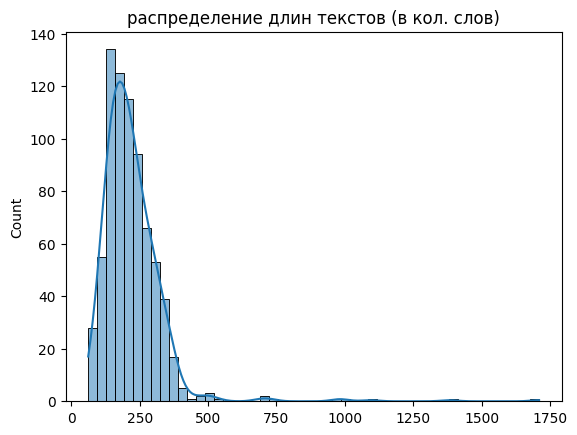

In [12]:
ax = sns.histplot(data=text_lens, bins=50, kde=True)
ax.set_title('распределение длин текстов (в кол. слов)');

In [13]:
pd.Series(text_lens).describe()

count     746.000000
mean      221.292225
std       119.721547
min        62.000000
25%       154.000000
50%       201.500000
75%       262.750000
max      1710.000000
dtype: float64

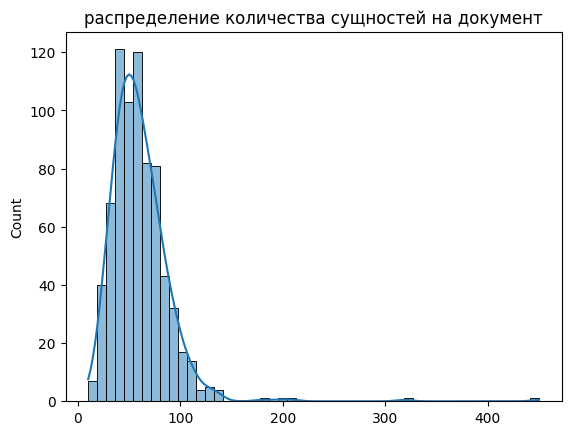

In [14]:
ax = sns.histplot(data=entities_per_doc, bins=50, kde=True)
ax.set_title('распределение количества сущностей на документ');

In [15]:
pd.Series(entities_per_doc).describe()

count    746.000000
mean      60.109920
std       29.857536
min       10.000000
25%       42.000000
50%       55.500000
75%       73.000000
max      450.000000
dtype: float64

### Выводы по EDA:
- Документы представляют собой новости.
- Сущности: страна, дата, организация, и т. д.
- Отношения: Организационные, локационные, временные и т. д.
- Всего уникальных сущностей 29
- Всего уникальных отношений 49
- График TOP-15 сущностей представлен выше (Person, Profession, Organization, Event, Date, ...)
- График TOP-15 отношений представлен выше (Workplace, Alternative_name, Works_as, ...)
- **Таким образом, наиболее частые новости - о работе людей и организаций, о бизнесе**
- медианная длина текста 201 слово, минимальная - 62, максимальная - 1710 - график распределения представлен выше, распределение похоже на нормальное со смещением влево
- медианная количество сущностей на документ - 56, минимальное - 10, максимальное - 450 - график распределения представлен выше, распределение похоже на нормальное со смещением влево

## 2. Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [16]:
top30_relations_list = [x[0] for x in top30_relations]
top30_relations_list

['WORKPLACE',
 'ALTERNATIVE_NAME',
 'WORKS_AS',
 'PARTICIPANT_IN',
 'POINT_IN_TIME',
 'TAKES_PLACE_IN',
 'HEADQUARTERED_IN',
 'ORIGINS_FROM',
 'LOCATED_IN',
 'AGENT',
 'AGE_IS',
 'HAS_CAUSE',
 'PRODUCES',
 'AWARDED_WITH',
 'PART_OF',
 'IDEOLOGY_OF',
 'MEMBER_OF',
 'CONVICTED_OF',
 'INANIMATE_INVOLVED',
 'SUBEVENT_OF',
 'SUBORDINATE_OF',
 'KNOWS',
 'MEDICAL_CONDITION',
 'PARENT_OF',
 'PLACE_RESIDES_IN',
 'OWNER_OF',
 'ABBREVIATION',
 'FOUNDED_BY',
 'ORGANIZES',
 'PENALIZED_AS']

In [17]:
len(records)

746

In [18]:
def whitespace_tokenize_with_offsets(text: str):
    tokens = []
    spans = []
    for m in re.finditer(r'\S+', text):
        tokens.append(m.group())
        spans.append((m.start(), m.end()))
    return tokens, spans

def build_examples_from_nerel(records: list[dict], event_list: list[str]) -> list[dict]:
    examples = []
    for rec in records:
        text = rec['text']
        tokens, token_spans = whitespace_tokenize_with_offsets(text)
        token_labels = ["O"] * len(tokens)

        parsed_entities = [parse_entity_line(entity) for entity in rec['entities']]
        for parsed in parsed_entities:
            is_token_1st = True
            span_start = parsed['start']
            span_end = parsed['end']
            entity_type = parsed['type']

            overlapping_idxs = []
            for i, (t_start, t_end) in enumerate(token_spans):
                if not (t_end <= span_start or t_start >= span_end):
                    overlapping_idxs.append(i)
            if not overlapping_idxs:
                continue
            for j, tok_idx in enumerate(overlapping_idxs):
                if token_labels[tok_idx] != "O":
                    continue
                if is_token_1st:
                    prefix = "B"
                    is_token_1st = False
                else:
                    prefix = "I"
                token_labels[tok_idx] = f"{prefix}-{entity_type}"

        cls_vec = [0] * len (event_list)
        parsed_relations = [parse_relation_line(entity) for entity in rec['relations']]
        for parsed in parsed_relations:
            rel_type = parsed['type']
            if rel_type in event_list:
                cls_vec [event_list.index(rel_type)] = 1

        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec
        })
    return examples

In [19]:
train_examples = build_examples_from_nerel (train_dataset, top30_relations_list)
test_examples = build_examples_from_nerel (test_dataset, top30_relations_list)

In [20]:
len(train_examples)

746

In [21]:
len(test_examples)

93

In [22]:
train_examples[:5]

[{'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба отмечает, что

## 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.

- Проверить shapes: input_ids, labels (с –100 для subword tokens), cls_labels.

In [23]:
unique_labels = set()
for ex in train_examples:
    unique_labels.update(ex["tags"])
label_list = sorted(unique_labels)
label_list.remove ("O")
label_list.insert(0, "O")
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

for ex in train_examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]

for ex in test_examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]


train_ds = Dataset.from_list(train_examples)
test_ds = Dataset.from_list(test_examples)

print(train_ds)
print(test_ds)

Dataset({
    features: ['text', 'tokens', 'token_spans', 'tags', 'cls_vec'],
    num_rows: 746
})
Dataset({
    features: ['text', 'tokens', 'token_spans', 'tags', 'cls_vec'],
    num_rows: 93
})


In [24]:
id2label

{0: 'O',
 1: 'B-AGE',
 2: 'B-AWARD',
 3: 'B-CITY',
 4: 'B-COUNTRY',
 5: 'B-CRIME',
 6: 'B-DATE',
 7: 'B-DISEASE',
 8: 'B-DISTRICT',
 9: 'B-EVENT',
 10: 'B-FACILITY',
 11: 'B-FAMILY',
 12: 'B-IDEOLOGY',
 13: 'B-LANGUAGE',
 14: 'B-LAW',
 15: 'B-LOCATION',
 16: 'B-MONEY',
 17: 'B-NATIONALITY',
 18: 'B-NUMBER',
 19: 'B-ORDINAL',
 20: 'B-ORGANIZATION',
 21: 'B-PENALTY',
 22: 'B-PERCENT',
 23: 'B-PERSON',
 24: 'B-PRODUCT',
 25: 'B-PROFESSION',
 26: 'B-RELIGION',
 27: 'B-STATE_OR_PROVINCE',
 28: 'B-TIME',
 29: 'B-WORK_OF_ART',
 30: 'I-AGE',
 31: 'I-AWARD',
 32: 'I-CITY',
 33: 'I-COUNTRY',
 34: 'I-CRIME',
 35: 'I-DATE',
 36: 'I-DISEASE',
 37: 'I-DISTRICT',
 38: 'I-EVENT',
 39: 'I-FACILITY',
 40: 'I-FAMILY',
 41: 'I-IDEOLOGY',
 42: 'I-LAW',
 43: 'I-LOCATION',
 44: 'I-MONEY',
 45: 'I-NATIONALITY',
 46: 'I-NUMBER',
 47: 'I-ORDINAL',
 48: 'I-ORGANIZATION',
 49: 'I-PENALTY',
 50: 'I-PERCENT',
 51: 'I-PERSON',
 52: 'I-PRODUCT',
 53: 'I-PROFESSION',
 54: 'I-STATE_OR_PROVINCE',
 55: 'I-TIME',
 56: 'I-

In [25]:
tokenizer = AutoTokenizer.from_pretrained(ENCODER_NAME)

In [26]:
def tokenize_and_align_labels (examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=TOKENIZER_MAX_LEN)
    labels = []
    word_ids_debug=[]
    for i, word_labels in enumerate(examples["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        word_idx_debug = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(word_labels[word_idx])
            else:
                label_ids.append(-100)
            word_idx_debug.append(word_idx)
            prev_word_idx = word_idx
        labels.append(label_ids)
        word_ids_debug.append(word_idx_debug)
    tokenized["labels"] = labels
    tokenized["word_ids_debug"] = word_ids_debug
    return tokenized

tokenized_train_dataset = train_ds.map(
    tokenize_and_align_labels, batched=True,
    remove_columns=["text", "tokens", "token_spans", "tags"] # cls_vec оставим 
)

tokenized_val_dataset = test_ds.map(
    tokenize_and_align_labels, batched=True,
    remove_columns=["text", "tokens", "token_spans", "tags"] # cls_vec оставим 
)

Map: 100%|██████████| 93/93 [00:00<00:00, 797.38 examples/s]


In [27]:
tokenized_train_dataset

Dataset({
    features: ['cls_vec', 'input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids_debug'],
    num_rows: 746
})

In [28]:
tokenized_train_dataset

Dataset({
    features: ['cls_vec', 'input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids_debug'],
    num_rows: 746
})

In [29]:
def custom_collator(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch], dtype=torch.long)
    attention_mask = torch.tensor([item["attention_mask"] for item in batch], dtype=torch.long)
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)
    cls_vec = torch.tensor([item["cls_vec"] for item in batch], dtype=torch.float)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "cls_vec": cls_vec
    }

train_dataloader = DataLoader(
    tokenized_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collator
)
val_dataloader = DataLoader(
    tokenized_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collator
)

## 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [ ]:
class JointModel(nn.Module):
    def __init__(self, encoder_name, num_token_labels, num_cls_labels):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        hidden = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(DROPOUT)

        # Голова для токенов (NER)
        self.token_cls = nn.Linear(hidden, num_token_labels)

        # Голова для CLS
        self.cls_cls = nn.Linear(hidden, num_cls_labels)
        
        # своя реализация loss
        self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)
        attn = attention_mask.unsqueeze(-1).float()               # [B, T, 1]
        pooled_output = (sequence_output * attn).sum(dim=1) / attn.sum(dim=1).clamp(min=1e-6)  # [B, H]
        pooled_output = self.dropout(pooled_output)
            
        # Токенный логит (NER)
        token_logits = self.token_cls(sequence_output)
        # Классификация всего текста
        cls_logits = self.cls_cls(pooled_output)
    
        return token_logits, cls_logits

## 5. Training / Validation



In [31]:
def compute_token_f1_macro_seqeval(preds, labels, id2label, pad_token_id=-100):
    true_seqs, pred_seqs = [], []
    for p, l in zip(preds, labels):
        true_seq, pred_seq = [], []
        for pi, li in zip(p, l):
            if li == pad_token_id:
                continue
            true_seq.append(id2label[li])
            pred_seq.append(id2label[pi])
        true_seqs.append(true_seq)
        pred_seqs.append(pred_seq)

    f1_macro = seqeval_f1(true_seqs, pred_seqs, average='macro')
    return f1_macro

def compute_cls_metrics(preds, targets):
    preds = (torch.sigmoid(preds) > 0.5).int().cpu().numpy().flatten()
    targets = targets.int().cpu().numpy().flatten()

    f1_micro = f1_score(targets, preds, average='micro')
    precision = precision_score(targets, preds, average='micro', zero_division=0)
    recall = recall_score(targets, preds, average='micro', zero_division=0)

    return f1_micro, precision, recall

In [32]:
def validate(model, dataloader, device):
    model.eval()
    all_token_preds, all_token_labels = [], []
    all_cls_preds, all_cls_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_labels = batch['labels'].to(device)
            cls_labels = batch['cls_vec'].to(device)

            token_logits, cls_logits = model(input_ids, attention_mask)
            token_preds = token_logits.argmax(dim=-1)

            all_token_preds.extend(token_preds.cpu().numpy())
            all_token_labels.extend(token_labels.cpu().numpy())
            all_cls_preds.append(cls_logits.cpu())
            all_cls_labels.append(cls_labels.cpu())

    # Метрика NER
    token_f1_macro = compute_token_f1_macro_seqeval(all_token_preds, 
                                                    all_token_labels, id2label)

    # Метрика CLS
    cls_preds_tensor = torch.cat(all_cls_preds)
    cls_labels_tensor = torch.cat(all_cls_labels)
    cls_f1_micro, cls_precision, cls_recall = \
        compute_cls_metrics(cls_preds_tensor, cls_labels_tensor)

    return token_f1_macro, cls_f1_micro, cls_precision, cls_recall


In [ ]:
def train(model, train_dataloader, val_dataloader, device):
    optimizer = torch.optim.AdamW([
        {'params': model.encoder.parameters(), 'lr': TEXT_LR},
        {'params': model.token_cls.parameters(), 'lr': LEARNING_RATE},
        {'params': model.cls_cls.parameters(), 'lr': LEARNING_RATE}
    ], weight_decay=WEIGHT_DECAY)

    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_MAX, eta_min=SCHEDULER_ETA_MIN)

    best_token_f1_macro = .0
    best_cls_f1_micro = .0

    all_total_token_loss = []
    all_total_cls_loss = []
    all_total_loss = []
    all_val_token_f1_macro = []
    all_val_cls_f1_micro = []

    scaler = torch.amp.GradScaler()
    for epoch in range(EPOCHS_MAX):
        model.train()
        total_loss = .0
        total_token_loss = .0
        total_cls_loss = .0
        
        for batch in train_dataloader:
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16): 
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_labels = batch['labels'].to(device)
                cls_labels = batch['cls_vec'].to(device)

                token_logits, cls_logits = model(input_ids, attention_mask)

                token_loss = model.token_loss_fct(token_logits.view(-1, token_logits.shape[-1]),
                                                token_labels.view(-1))
                cls_loss = model.cls_loss_fct(cls_logits, cls_labels.float())
                
                loss_token_term = torch.exp(-2.0 * model.log_sigma_token) * token_loss + model.log_sigma_token
                loss_cls_term = torch.exp(-2.0 * model.log_sigma_cls) * cls_loss + model.log_sigma_cls
                loss = loss_token_term + loss_cls_term

            scaler.scale(loss).backward()  # масштабируем loss и считаем градиенты
            scaler.step(optimizer)         # обновляем параметры
            scaler.update()               # обновляем масштаб для следующей итерации 
            
        scheduler.step()

        total_token_loss += token_loss.item()
        total_cls_loss += cls_loss.item()
        total_loss += loss.item()

        # валидация
        model.eval()
        val_token_f1_macro, val_cls_f1_micro, val_cls_prec, val_cls_rec \
            = validate(model, val_dataloader, device)

        all_total_token_loss.append(total_token_loss/len(train_dataloader))
        all_total_cls_loss.append(total_cls_loss/len(train_dataloader))
        all_total_loss.append(total_cls_loss/len(train_dataloader))
        all_val_token_f1_macro.append(val_token_f1_macro)
        all_val_cls_f1_micro.append(val_cls_f1_micro)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS_MAX}"\
                    f" | Token loss: {all_total_token_loss[-1]:.4f}"\
                    f" | CLS loss: {all_total_cls_loss[-1]:.4f}"\
                    f" | Total loss: {all_total_loss[-1]:.4f}"\
                    f" | Token-F1 (macro): {all_val_token_f1_macro[-1]:.4f}"\
                    f" | CLS micro-F1: {all_val_cls_f1_micro[-1]:.4f}")

        if val_token_f1_macro > best_token_f1_macro:
            best_token_f1_macro = val_token_f1_macro
        if val_cls_f1_micro > best_cls_f1_micro:
            best_cls_f1_micro = val_cls_f1_micro

        # критерий успеха
        if best_token_f1_macro >= TARGET_TOKEN_MACRO_F1 \
            and best_cls_f1_micro >= TARGET_CLS_MICRO_F1:
            print(f"\nКритерий успеха достигнут на эпохе {epoch+1}")
            break
    all_total_token_loss_float = [loss.item() if isinstance(loss, torch.Tensor) 
                                  else loss for loss in all_total_token_loss]
    all_total_cls_loss_float = [loss.item() if isinstance(loss, torch.Tensor) 
                                else loss for loss in all_total_cls_loss]
    all_val_token_f1_macro_float = [loss.item() if isinstance(loss, torch.Tensor) 
                                    else loss for loss in all_val_token_f1_macro]
    all_val_cls_f1_micro_float = [loss.item() if isinstance(loss, torch.Tensor) 
                                  else loss for loss in all_val_cls_f1_micro]

    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(all_total_token_loss_float)+1), 
             all_total_token_loss_float, label='token_loss', linestyle='--', color='gray')
    plt.plot(range(1, len(all_total_cls_loss_float)+1), 
             all_total_cls_loss_float, label='cls_loss', linestyle='--', color='black')
    plt.plot(range(1, len(all_val_token_f1_macro_float)+1), 
             all_val_token_f1_macro_float, label='token_f1_macro', color='red')
    plt.plot(range(1, len(all_val_cls_f1_micro_float)+1), 
             all_val_cls_f1_micro_float, label='cls_f1_micro', color='blue')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.title('Графики Loss и f1')
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
print (device)
for i in range(torch.cuda.device_count()):
    print(f"GPU-{i}: {torch.cuda.get_device_name(i)}")

cuda
GPU-0: Tesla V100-SXM2-16GB


In [36]:
model = JointModel (ENCODER_NAME, len(label_list), RELATIONS_MAX_LEN)
model = model.to(device)

Epoch 1/3000 | Token loss: 0.1440 | CLS loss: 0.0275 | Total loss: 0.0275 | Token-F1 (macro): 0.0056 | CLS micro-F1: 0.6122
Epoch 11/3000 | Token loss: 0.0519 | CLS loss: 0.0211 | Total loss: 0.0211 | Token-F1 (macro): 0.0558 | CLS micro-F1: 0.7778
Epoch 21/3000 | Token loss: 0.0406 | CLS loss: 0.0189 | Total loss: 0.0189 | Token-F1 (macro): 0.1425 | CLS micro-F1: 0.7781
Epoch 31/3000 | Token loss: 0.0277 | CLS loss: 0.0198 | Total loss: 0.0198 | Token-F1 (macro): 0.2030 | CLS micro-F1: 0.7796
Epoch 41/3000 | Token loss: 0.0274 | CLS loss: 0.0188 | Total loss: 0.0188 | Token-F1 (macro): 0.2683 | CLS micro-F1: 0.7839
Epoch 51/3000 | Token loss: 0.0186 | CLS loss: 0.0179 | Total loss: 0.0179 | Token-F1 (macro): 0.3288 | CLS micro-F1: 0.7968
Epoch 61/3000 | Token loss: 0.0175 | CLS loss: 0.0179 | Total loss: 0.0179 | Token-F1 (macro): 0.3739 | CLS micro-F1: 0.8022
Epoch 71/3000 | Token loss: 0.0151 | CLS loss: 0.0165 | Total loss: 0.0165 | Token-F1 (macro): 0.4063 | CLS micro-F1: 0.8068
E

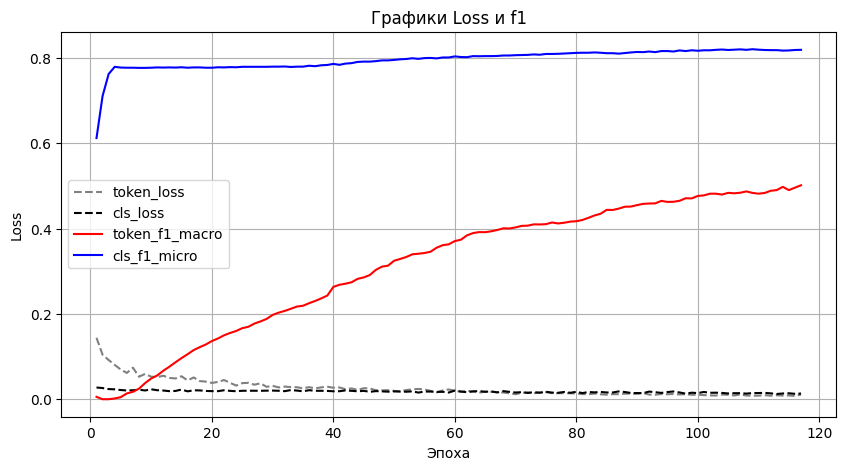

CPU times: user 4min 9s, sys: 39.1 s, total: 4min 48s
Wall time: 4min 49s


In [37]:
%%time
train(model, train_dataloader, val_dataloader, device)

torch.save(model.state_dict(), "trained_model.pth")

In [38]:
pd.options.display.max_columns = 800
pd.DataFrame({'tokens':train_ds[0]['tokens'],
              'tags':train_ds[0]['tags']}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370
tokens,"Пулеметы,",автоматы,и,снайперские,винтовки,изъяты,в,арендуемом,американцами,доме,в,Бишкеке,05/08/2008,10:35,"БИШКЕК,",5,августа,/Новости-Грузия/.,Правоохранительные,органы,Киргизии,обнаружили,в,"доме,",арендуемом,гражданами,США,в,"Бишкеке,","пулеметы,",автоматы,и,снайперские,"винтовки,",сообщает,во,вторник,пресс-служба,МВД,Киргизии.,"""В",ходе,проведения,оперативно-профилактического,мероприятия,под,кодовым,названием,"""Арсенал""",в,новостройке,"Ынтымак,",в,"доме,",принадлежащем,66-летнему,гражданину,Киргизии,и,арендуемом,гражданами,"США,",обнаружены,и,изъяты:,шесть,крупнокалиберных,пулеметов,с,оптическим,прицелом,и,с,приборами,ночного,"видения,",26,автоматов,калибра,"5,56","миллиметра,",два,винчестера,марки,МОСВЕГА,12-го,"калибра,",четыре,ствола,от,крупнокалиберного,"пулемета,",два,подствольных,"гранатомета,",четыре,снайперские,винтовки,с,оптическим,прицелом,защитного,"цвета,",шесть,пистолетов,калибра,9,миллиметров,марки,"Беретта,",одна,"винтовка"",",-,говорится,в,сообщении,МВД.,Пресс-служба,"отмечает,",что,на,момент,обыска,"""в",доме,находились,несколько,сотрудников,посольства,"США,",обладающих,дипломатическим,"иммунитетом,",и,10,"военнослужащих,",якобы,прибывших,из,США,для,проведения,тренинга,с,сотрудниками,спецподразделения,одной,из,силовых,структур,"республики,",личности,которых,в,настоящее,время,"устанавливаются"".",Согласно,"сообщению,",в,доме,было,обнаружено,и,значительное,количество,боеприпасов.,"""Два","ножа,",2920,штук,патронов,калибра,"5,56","миллиметра,",10556,штук,патронов,калибра,9,"миллиметров,",два,ящика,патронов,калибра,50,"миллиметров,",в,каждом,350,"штук,",патроны,калибра,12,миллиметров,в,количестве,478,"штук,",маркировочные,(трассирующие),патроны,(красного,цвета),1000,"штук,",66,штук,пустых,магазинов,от,автоматического,"оружия,",57,штук,пустых,магазинов,от,пистолета,"Беретта"",",-,говорится,в,пресс-релизе.,Пресс-служба,МВД,"сообщила,",что,расследование,по,данному,факту,проводит,прокуратура,Бишкека.,Сейчас,"выясняется,",кому,именно,принадлежит,изъятое,"оружие,",передает,РИА,Новости.,"Оружие,",изъятое,у,граждан,США,правоохранительными,органами,"Киргизии,",находилось,в,республике,с,ведома,правительства,"Киргизии,",сообщил,во,вторник,представитель,пресс-службы,посольства,США.,"""Все",оборудование,находилось,на,территории,Киргизии,с,ведома,и,разрешения,киргизских,"властей"",",-,сказал,собеседник,агентства.,Военнослужащие,и,оружие,"""прибыли",в,республику,по,приглашению,правительства,с,целью,обеспечения,антитеррористических,учений,для,"министерств"",",заявило,американское,дипломатическое,ведомство.,"""Дом",и,оборудование,находились,под,защитой,киргизских,"в

In [39]:
pd.DataFrame({'labels':tokenized_train_dataset[0]['labels'],
              'input_ids':tokenized_train_dataset[0]['input_ids'],
              'word_ids_debug':tokenized_train_dataset[0]['word_ids_debug'],
              'attention_mask':tokenized_train_dataset[0]['attention_mask']
              }).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
labels,-100.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,-100.0,17.0,0.0,0.0,3.0,-100.0,6.0,-100.0,-100.0,-100.0,-100.0,28.0,-100.0,-100.0,3.0,-100.0,-100.0,-100.0,-100.0,-100.0,6.0,35.0,4.0,-100.0,-100.0,-100.0,-100.0,-100.0,20.0,-100.0,48.0,48.0,0.0,0.0,0.0,-100.0,0.0,-100.0,17.0,4.0,0.0,3.0,-100.0,-100.0,0.0,-100.0,-100.0,0.0,0.0,0.0,-100.0,0.0,-100.0,0.0,6.0,35.0,20.0,-100.0,-100.0,20.0,20.0,-100.0,0.0,-100.0,0.0,0.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,-100.0,0.0,9.0,-100.0,-100.0,0.0,0.0,-100.0,3.0,-100.0,-100.0,-100.0,0.0,0.0,-100.0,0.0,-100.0,1.0,-100.0,-100.0,17.0,4.0,0.0,0.0,-100.0,17.0,4.0,-100.0,9.0,38.0,38.0,-100.0,18.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,-100.0,18.0,0.0,0.0,18.0,-100.0,-100.0,46.0,-100.0,-100.0,18.0,0.0,-100.0,-100.0,0.0,24.0,-100.0,-100.0,-100.0,-100.0,18.0,-100.0,-100.0,46.0,-100.0,18.0,0.0,0.0,0.0,-100.0,0.0,-100.0,18.0,0.0,-100.0,-100.0,0.0,-100.0,-100.0,18.0,0.0,-100.0,0.0,0.0,0.0,-100.0,0.0,-100.0,0.0,0.0,-100.0,18.0,0.0,0.0,18.0,46.0,0.0,24.0,-100.0,-100.0,18.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,20.0,-100.0,0.0,-100.0,-100.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,25.0,20.0,4.0,-100.0,0.0,0.0,-100.0,0.0,-100.0,-100.0,0.0,18.0,25.0,-100.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,-100.0,0.0,25.0,53.0,-100.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,-100.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,18.0,-100.0,0.0,-100.0,18.0,-100.0,0.0,0.0,0.0,18.0,-100.0,-100.0,46.0,-100.0,-100.0,18.0,-100.0,-100.0,0.0,0.0,0.0,18.0,46.0,-100.0,18.0,0.0,0.0,0.0,18.0,46.0,-100.0,0.0,0.0,18.0,0.0,-100.0,0.0,0.0,18.0,46.0,0.0,0.0,18.0,0.0,-100.0,0.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,0.0,0.0,-100.0,0.0,-100.0,18.0,0.0,-100.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,18.0,0.0,0.0,0.0,0.0,0.0,24.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,-100.0,-100.0,-100.0,20.0,-100.0,-100.0,20.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,-100.0,-100.0,28.0,0.0,-100.0,0.0,0.0,0.0,0.0,-100.0,0.0,-100.0,0.0,20.0,48.0,-100.0,0.0,-100.0,0.0,-100.0,0.0,17.0,4.0,20.

### Выводы обучению (на одной GPU Tesla V100-SXM2-16GB)
- классификатор по токенам обучался гораздо сложнее, чем по отношениям. Обучение остановилось по достижению целевых метрик.
- с квантизацией он обучался дольше по времени, при этом качество обучения, судя по графикам f1 на валидации - примерно такое же.



| | Изначальное обучению без квантизации: | Обучение с квантизацией|
|----------|----------|----------|
| Epoch | 111/3000    | Epoch 111/3000|
| Token loss: |0.0082    |0.0087|
| CLS loss: |0.0146    |0.0155|
| Total loss: |0.0146    |0.0155|
| Token-F1 (macro): |0.5102    |0.4948|
| CLS micro-F1: |0.8204    |0.8183|
| CPU times: |user 2min 51s, sys: 16.6 s, total: 3min 7s   | user 4min 9s, sys: 39.1 s, total: 4min 48s|
| Wall time: | 3min 8s    | 4min 49s |
| бэкап картинки| 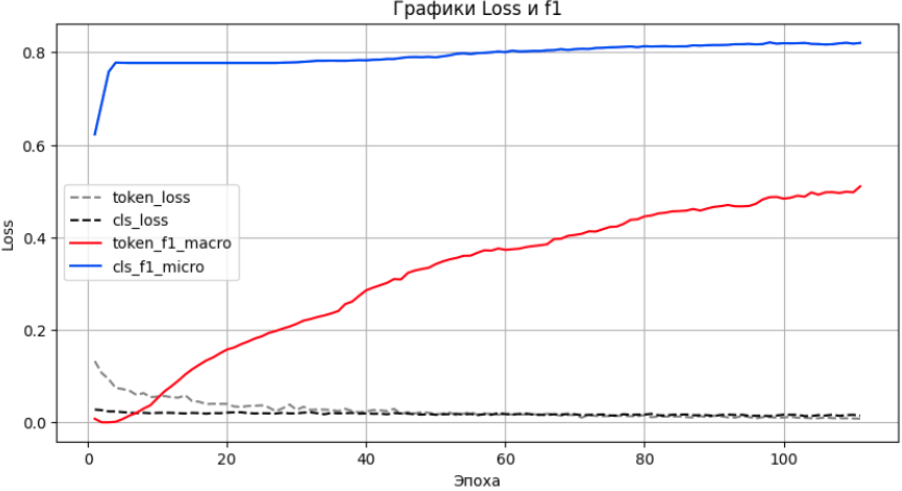        |   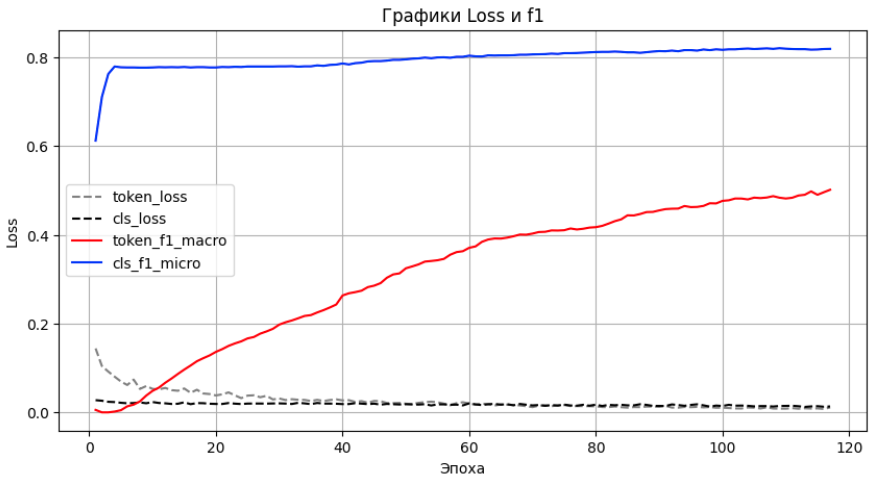|


## 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?

In [40]:
test_texts = [test_dataset[i]['text'] for i in range(10)]
test_texts

['Словацкий тренер Жолт Хорняк возглавил "Бананц" (Ереван)\n\nСловацкий тренер Жолт Хорняк стал новым главным тренером футбольного клуба "Бананц" (Ереван). Контракт с 40 летним тренером был подписан по системе "1+1", - сообщает пресс-служба столичного клуба.\n\nОтметим, что на посту главного тренера "Бананца" Хорняк заменил украинского специалиста Владимира Пятенко.\n\nНапомним, что в прошедшем сезоне Хорняк тренировал "Мику", которую привел к серебряным медалям чемпионата Армении.',
 'Глава департамента ЦБ РФ Надежда Иванова получила статус зампреда\n\nИванова, которой 13 июня исполнилось 60 лет, всю свою жизнь проработала в системе ЦБ. Сводный экономический департамент Банка России возглавляет с 1995 года.\nЗдание Центрального банка РФ. Архив\n\nДиректор сводного экономического департамента Банка России Надежда Иванова назначена также на должность заместителя председателя ЦБ, сообщил в четверг регулятор.\n\n\n\nИванова, у которой 13 июня был 60-летний юбилей, работает в системе Банка

In [41]:
def inference(model, text, device):
    
    tokens, spans = whitespace_tokenize_with_offsets(text)
    
    tokenized = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=TOKENIZER_MAX_LEN,
        return_tensors="pt")
        
    model.eval()
    with torch.no_grad():
        input_ids = tokenized['input_ids'].to(device)
        attention_mask = tokenized['attention_mask'].to(device)

        token_logits, cls_logits = model(input_ids, attention_mask)
        token_preds = token_logits.argmax(dim=-1)

        cls_preds = (torch.sigmoid(cls_logits) > 0.5).int().cpu().numpy().flatten()

    token_preds = token_preds.to('cpu').numpy()[0]
    
    words_preds = ["O"]*len(tokens)

    word_ids = tokenized.word_ids (batch_index=0)
    token_preds = [ id2label[t] for t in token_preds]
    for i, w in enumerate(word_ids):
        if w is not None:
            words_preds[w] = token_preds[i]

    cls_preds = [top30_relations_list[c] for c in cls_preds]
    
    print (text)
    
    df = pd.DataFrame({'tokens':tokens,'words_preds':words_preds}).T

    print (f"Найденные в тексте отношения: {cls_preds}")
    display (df)

for i in range (10):
    print (f"Текст-{i+1} --------------->")
    inference(model, test_texts[i], device)

Текст-1 --------------->
Словацкий тренер Жолт Хорняк возглавил "Бананц" (Ереван)

Словацкий тренер Жолт Хорняк стал новым главным тренером футбольного клуба "Бананц" (Ереван). Контракт с 40 летним тренером был подписан по системе "1+1", - сообщает пресс-служба столичного клуба.

Отметим, что на посту главного тренера "Бананца" Хорняк заменил украинского специалиста Владимира Пятенко.

Напомним, что в прошедшем сезоне Хорняк тренировал "Мику", которую привел к серебряным медалям чемпионата Армении.
Найденные в тексте отношения: ['ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'WORKPLACE', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE', 'WORKPLACE']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
tokens,Словацкий,тренер,Жолт,Хорняк,возглавил,"""Бананц""",(Ереван),Словацкий,тренер,Жолт,Хорняк,стал,новым,главным,тренером,футбольного,клуба,"""Бананц""",(Ереван).,Контракт,с,40,летним,тренером,был,подписан,по,системе,"""1+1"",",-,сообщает,пресс-служба,столичного,клуба.,"Отметим,",что,на,посту,главного,тренера,"""Бананца""",Хорняк,заменил,украинского,специалиста,Владимира,Пятенко.,"Напомним,",что,в,прошедшем,сезоне,Хорняк,тренировал,"""Мику"",",которую,привел,к,серебряным,медалям,чемпионата,Армении.
words_preds,I-PROFESSION,B-PROFESSION,I-PERSON,I-PERSON,B-EVENT,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PERSON,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,O,O,B-DATE,B-AGE,I-DATE,B-PROFESSION,O,B-EVENT,O,O,O,O,O,I-ORGANIZATION,B-ORGANIZATION,O,O,O,O,O,B-PROFESSION,I-PROFESSION,B-PERSON,I-PERSON,O,B-NATIONALITY,O,B-PERSON,O,O,O,O,O,O,B-PERSON,O,O,O,O,O,B-AWARD,O,I-EVENT,O


Текст-2 --------------->
Глава департамента ЦБ РФ Надежда Иванова получила статус зампреда

Иванова, которой 13 июня исполнилось 60 лет, всю свою жизнь проработала в системе ЦБ. Сводный экономический департамент Банка России возглавляет с 1995 года.
Здание Центрального банка РФ. Архив

Директор сводного экономического департамента Банка России Надежда Иванова назначена также на должность заместителя председателя ЦБ, сообщил в четверг регулятор.



Иванова, у которой 13 июня был 60-летний юбилей, работает в системе Банка России (ранее — Госбанка СССР) с окончания института, то есть с 1975 года. Сводный экономический департамент возглавляет почти 20 лет — с 1995 года.

Иванова входит в совет директоров Центробанка. До сводного экономического департамента она трудилась в департаменте банковского надзора.

Сводный экономический департамент входит в блок денежно-кредитной политики.

Это первое назначение нового председателя Банка России Эльвиры Набиуллиной на этом посту. Раньше в руководств

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
tokens,Глава,департамента,ЦБ,РФ,Надежда,Иванова,получила,статус,зампреда,"Иванова,",которой,13,июня,исполнилось,60,"лет,",всю,свою,жизнь,проработала,в,системе,ЦБ.,Сводный,экономический,департамент,Банка,России,возглавляет,с,1995,года.,Здание,Центрального,банка,РФ.,Архив,Директор,сводного,экономического,департамента,Банка,России,Надежда,Иванова,назначена,также,на,должность,заместителя,председателя,"ЦБ,",сообщил,в,четверг,регулятор.,"Иванова,",у,которой,13,июня,был,60-летний,"юбилей,",работает,в,системе,Банка,России,(ранее,—,Госбанка,СССР),с,окончания,"института,",то,есть,с,1975,года.,Сводный,экономический,департамент,возглавляет,почти,20,лет,—,с,1995,года.,Иванова,входит,в,совет,директоров,Центробанка.,До,сводного,экономического,департамента,она,трудилась,в,департаменте,банковского,надзора.,Сводный,экономический,департамент,входит,в,блок,денежно-кредитной,политики.,Это,первое,назначение,нового,председателя,Банка,России,Эльвиры,Набиуллиной,на,этом,посту.,Раньше,в,руководстве,Центробанка,преобладали,мужчины.,Эксперты,ждут,назначения,на,пост,первого,зампреда,ЦБ,по,вопросам,денежно-кредитной,политики,Ксении,"Юдаевой,",возглавляющей,экспертное,управление,президента,РФ.,Ранее,этот,пост,занимал,Алексей,"Улюкаев,",который,в,понедельник,стал,руководителем,Минэкономразвития.
words_preds,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,B-PERSON,I-PERSON,O,O,I-PROFESSION,O,O,B-DATE,I-DATE,O,B-AGE,O,O,O,O,O,O,O,O,O,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,O,B-DATE,I-DATE,O,B-FACILITY,I-ORGANIZATION,I-ORGANIZATION,O,B-ORGANIZATION,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-ORGANIZATION,I-ORGANIZATION,B-PERSON,I-PERSON,O,O,O,O,B-PROFESSION,I-PROFESSION,O,O,B-DATE,I-DATE,O,O,O,O,B-DATE,I-DATE,O,I-AGE,O,O,O,O,B-ORGANIZATION,I-ORGANIZATION,O,O,I-ORGANIZATION,O,O,O,O,O,O,B-DATE,I-DATE,O,O,I-ORGANIZATION,I-ORGANIZATION,O,B-DATE,I-DATE,I-DATE,O,B-DATE,I-DATE,O,B-PERSON,O,O,B-ORGANIZATION,I-ORGANIZATION,O,O,O,O,I-ORGANIZATION,O,O,O,B-ORGANIZATION,I-ORGANIZATION,O,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,O,O,O,I-ORGANIZATION,O,O,B-ORDINAL,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,O,O,O,O,O,O,O,B-ORGANIZATION,O,O,O,O,O,O,O,B-PROFESSION,I-PROFESSION,B-ORGANIZATION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,B-PERSON,O,O,I-PROFESSION,I-PROFESSION,I-PROFESSION,O,O,O,O,O,B-PERSON,O,O,B-DATE,I-DATE,O,B-PROFESSION,I-PROFESSION


Текст-3 --------------->
Умер самый старый миллиардер в мире Дэвид Рокфеллер

Дэвид Рокфеллер 24 октября 1953 года
В США в возрасте 101 года скончался американский миллиардер Дэвид Рокфеллер старший.
Информацию подтвердил официальный представитель семьи погибшего Фрейзер Сетел ().

Дэвид Рокфеллер умер в понедельник, 20 марта 2017 года, во сне от застойной сердечной недостаточности в своём родовом имении в Покантико-Хиллз в штате Нью-Йорк.

Отмечается, что ранее скончавшийся обладал значительным политическим влиянием в Соединённых Штатах.

Родившийся 12 июня 1915 года американский банкир, государственный деятель, глобалист и глава дома Рокфеллеров Дэвид Рокфеллер старший () — внук нефтяного магната и первого в истории долларового миллиардера Джона Дэвисона Рокфеллера, основателя Стандарт Ойл, младший брат 41-го вице-президента США Нельсона Рокфеллера и 37-го губернатора Арканзаса Уинтропа О. Рокфеллера. Первый представитель династии, достигший столетия.

В правой среде он вызывал недов

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318
tokens,Умер,самый,старый,миллиардер,в,мире,Дэвид,Рокфеллер,Дэвид,Рокфеллер,24,октября,1953,года,В,США,в,возрасте,101,года,скончался,американский,миллиардер,Дэвид,Рокфеллер,старший.,Информацию,подтвердил,официальный,представитель,семьи,погибшего,Фрейзер,Сетел,().,Дэвид,Рокфеллер,умер,в,"понедельник,",20,марта,2017,"года,",во,сне,от,застойной,сердечной,недостаточности,в,своём,родовом,имении,в,Покантико-Хиллз,в,штате,Нью-Йорк.,"Отмечается,",что,ранее,скончавшийся,обладал,значительным,политическим,влиянием,в,Соединённых,Штатах.,Родившийся,12,июня,1915,года,американский,"банкир,",государственный,"деятель,",глобалист,и,глава,дома,Рокфеллеров,Дэвид,Рокфеллер,старший,(),—,внук,нефтяного,магната,и,первого,в,истории,долларового,миллиардера,Джона,Дэвисона,"Рокфеллера,",основателя,Стандарт,"Ойл,",младший,брат,41-го,вице-президента,США,Нельсона,Рокфеллера,и,37-го,губернатора,Арканзаса,Уинтропа,О.,Рокфеллера.,Первый,представитель,"династии,",достигший,столетия.,В,правой,среде,он,вызывал,недовольство,"тем,",что,пытался,добиться,свободной,торговли,с,Китаем,и,СССР,во,времена,«холодной,войны».,Трёхсторонняя,"комиссия,",основанная,Рокфеллером,в,1973,году,для,развития,отношений,между,Северной,"Америкой,",Японией,и,Западной,"Европой,",стала,объектом,регулярных,нападок,со,стороны,ультраправых,и,"конспирологов,",которые,"считали,",что,он,пытается,создать,единое,для,всего,мира,правительство.,В,1979,году,Рокфеллер,оказался,замешан,в,международном,"скандале,",когда,вместе,со,своим,давним,другом,Генри,Киссинджером,помог,убедить,президента,Джимми,Картера,позволить,иранскому,шаху,приехать,в,США,на,лечение,от,"лимфомы,",что,стало,одной,из,предпосылок,кризиса,с,захватом,заложников,в,Иране.,В,опубликованном,20,марта,2017,года,рейтинге,миллиардеров,''Forbes'',Рокфеллер,занял,581-е,место,с,состоянием,"$3,3",млрд,и,считался,самым,старым,на,Земле,миллиардером.,В,течение,жизни,он,отдал,на,благотворительность,почти,2,миллиарда,долларов,США.,Рокфеллер,также,основал,несколько,международных,и,благотворительных,организаций:,Americas,"Society,",влиятельную,Трёхстороннюю,комиссию,и,некоммерческую,организацию,помощи,малообеспеченным,ньюйоркцам,New,York,City,Partnership.,Рокфеллер,всю,жизнь,коллекционировал,"жуков,",а,также,скупал,произведения,искусства,–,картина,Марка,"Ротко,",которую,он,приобрёл,в,1960,году,"меньше,",чем,за,"долларов,",в,мае,2007,года,ушла,с,молотка,"более,",чем,за,72,миллиона,долларов.
words_preds,B-EVENT,O,O,B-PROFESSION,O,O,B-PERSON,I-PERSON,B-PERSON,I-PERSON,B-DATE,I-DATE,I-DATE,I-DATE,O,B-COUNTRY,O,O,B-AGE,I-AGE,B-EVENT,B-NATIONALITY,B-PROFESSION,B-PERSON,I-PERSON,O,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,B-PROFESSION,B-PERSON,I-PERSON,B-EVENT,B-DATE,O,I-DATE,I-DATE,I-DATE,O,O,O,O,I-DISEASE,I-DISEASE,I-DISEASE,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-COUNTRY,O,O,B-D

Текст-4 --------------->
Медалью ордена "За заслуги перед Чувашской Республикой" награждён премьер

40-летний премьер-министр Чувашии Иван Моторин награждён медалью ордена "За заслуги перед Чувашской Республикой". Как передаёт корреспондент ИА REGNUM, соответствующий указ подписал глава Чувашии Михаил Игнатьев. В указе отмечено, что награда присуждается "за многолетний плодотворный труд во благо Чувашской Республики".

Напомним, Иван Моторин назначен премьером 23 декабря 2011 года, куда он перешёл с должности главы Минэкономразвития республики в статусе вице-премьера. Министром экономики он проработал более 5,5 лет.

Отметим, Иван Моторин - трётий по счёту премьер-министр в правительстве Михаила Игнатьева, который возглавил республику в августе 2010 года. Как ранее сообщало ИА REGNUM, первым председателем Кабинета министров в обновлённом составе правительстве стала экс-глава Минздравсоцразвития Нина Суслонова, которая возглавила Кабмин ещё при первом президенте Чувашии Николае Федорове

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406
tokens,Медалью,ордена,"""За",заслуги,перед,Чувашской,"Республикой""",награждён,премьер,40-летний,премьер-министр,Чувашии,Иван,Моторин,награждён,медалью,ордена,"""За",заслуги,перед,Чувашской,"Республикой"".",Как,передаёт,корреспондент,ИА,"REGNUM,",соответствующий,указ,подписал,глава,Чувашии,Михаил,Игнатьев.,В,указе,"отмечено,",что,награда,присуждается,"""за",многолетний,плодотворный,труд,во,благо,Чувашской,"Республики"".","Напомним,",Иван,Моторин,назначен,премьером,23,декабря,2011,"года,",куда,он,перешёл,с,должности,главы,Минэкономразвития,республики,в,статусе,вице-премьера.,Министром,экономики,он,проработал,более,"5,5",лет.,"Отметим,",Иван,Моторин,-,трётий,по,счёту,премьер-министр,в,правительстве,Михаила,"Игнатьева,",который,возглавил,республику,в,августе,2010,года.,Как,ранее,сообщало,ИА,"REGNUM,",первым,председателем,Кабинета,министров,в,обновлённом,составе,правительстве,стала,экс-глава,Минздравсоцразвития,Нина,"Суслонова,",которая,возглавила,Кабмин,ещё,при,первом,президенте,Чувашии,Николае,Федорове,-,9,апреля,2010,года.,Менее,чем,через,полгода,после,переназначения,на,премьерский,"пост,",в,феврале,2011,"года,",она,ушла,в,отставку.,Затем,премьер-министром,был,назначен,руководитель,одного,из,дивизионов,молочного,концерна,Олег,"Макаров,",который,был,во,главе,чувашского,правительства,около,девяти,месяцев.,Обе,отставки,были,приняты,"""по","просьбе""",председателей,правительства.,"Напомним,",за,последний,год,в,числе,награждённых,медалью,ордена,-,Константин,"Косачёв,",в,течение,12,лет,представлявший,Чувашию,в,Госдуме,и,весной,2012,года,назначенный,руководителем,"Россотрудничества,",а,также,марафонка,Татьяна,"Архипова,",велоспортсменка,Ирина,Калентьева,и,её,тренер,Владимир,"Краснов,",удостоенные,награды,по,итогам,Олимпиады,в,Лондоне.,"Всего,",по,данным,администрации,главы,"Чувашии,",с,2009,года,по,первое,полугодие,2013,года,медалью,ордена,"""За",заслуги,перед,Чувашской,"Республикой""",награждены,105,"человек,",ордена,"""За",заслуги,перед,Чувашской,"Республикой""",удостоен,21,человек.,Справка,ИА,REGNUM.,Иван,Борисович,Моторин,родился,10,января,1973,года,в,Казахстане,в,г.,Усть-Каменогорске.,В,1995,году,окончил,Чувашский,государственный,университет,им.,И.Н.,Ульянова,по,специальности,"""экономист"".",После,окончания,вуза,работал,экспедитором-бухгалтером,в,ООО,"""Ким"".",С,апреля,1998,года,по,май,1999,года,был,на,должности,ведущего,специалиста,в,Министерстве,внешних,связей,"Чувашии,",затем,-,главного,специалиста,в,Министерстве,"предпринимательства,"

Текст-5 --------------->
Depeche Mode выпустил новый альбом Spirit

Выступление Depeche Mode в Австрии в 2013 году
17 марта 2017 года британская группа ''Depeche Mode'' выпустила четырнадцатый студийный альбом под названием ''Spirit'' (с англ. — «дух»).

''Spirit'' называют «первой политической пластинкой» группы, которая раньше не обращалась к такой тематике.

Уже в первой песне лидер ''Depeche Mode'' Дейв Гаан объявляет, что мир катится в ад, а во второй спрашивает: «И где же революция?»

Автор почти всех песен Мартин Гор сообщил, что придумал материал для пластинки ещё в 2015 году, но сейчас ''Spirit'' выглядит как реакция сразу на все мировые потрясения — от ''Brexit'' и до избрания Дональда Трампа президентом США, а также как обвинительное заключение в адрес тех, кто это допустил.
Так, Дэйв Гаан рассказал, что из-за результатов президентских выборов в США плакала даже его 16-летняя дочь Роуз.

Саунд-продюсером альбома выступил участник группы ''Simian Mobile Disco'' Джеймс Форд (J

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334
tokens,Depeche,Mode,выпустил,новый,альбом,Spirit,Выступление,Depeche,Mode,в,Австрии,в,2013,году,17,марта,2017,года,британская,группа,''Depeche,Mode'',выпустила,четырнадцатый,студийный,альбом,под,названием,''Spirit'',(с,англ.,—,«дух»).,''Spirit'',называют,«первой,политической,пластинкой»,"группы,",которая,раньше,не,обращалась,к,такой,тематике.,Уже,в,первой,песне,лидер,''Depeche,Mode'',Дейв,Гаан,"объявляет,",что,мир,катится,в,"ад,",а,во,второй,спрашивает:,«И,где,же,революция?»,Автор,почти,всех,песен,Мартин,Гор,"сообщил,",что,придумал,материал,для,пластинки,ещё,в,2015,"году,",но,сейчас,''Spirit'',выглядит,как,реакция,сразу,на,все,мировые,потрясения,—,от,''Brexit'',и,до,избрания,Дональда,Трампа,президентом,"США,",а,также,как,обвинительное,заключение,в,адрес,"тех,",кто,это,допустил.,"Так,",Дэйв,Гаан,"рассказал,",что,из-за,результатов,президентских,выборов,в,США,плакала,даже,его,16-летняя,дочь,Роуз.,Саунд-продюсером,альбома,выступил,участник,группы,''Simian,Mobile,Disco'',Джеймс,Форд,(James,"Ford),",уже,работавший,над,дисками,коллективов,''Florence,and,The,Machine'',и,''Arctic,Monkeys''.,17,марта,2017,года,группа,сделала,онлайн,презентацию,альбома,в,Берлине,при,поддержке,компании,T-Mobile.,На,берлинское,выступление,билеты,не,продавали,(их,разыгрывали,на,международном,конкурсе;,несколько,человек,приехали,из,России).,Трансляция,велась,онлайн,на,весь,мир,через,YouTube.,На,концерте,были,представлены,как,"новые,",так,и,старые,композиции.,Ранее,''Depeche,Mode'',[https://www.youtube.com/watch?v=jsCR05oKROA,выпустили,клип,на,песню],''Whereʼs,the,"Revolution'',",который,снял,бессменный,режиссёр,большинства,видео,"группы,",легендарный,фотограф,''Антон,Корбейн''.,В,чёрно-белом,ролике,Дэйв,"Гаан,",Мартин,Гор,и,Энди,Флетчер,превращаются,в,политиков,и,выступают,с,"трибуны,",призывая,общество,к,радикальным,переменам.,Группа,анонсировала,мировой,тур,Global,Spirit,Tour,(англ.),в,поддержку,нового,альбома,ещё,11,октября,2016,года,.,Европейская,часть,тура,начнётся,5,мая,концертом,в,Стокгольме,(Швеция),и,закончится,23,июля,в,Клуж-Напока,(Румыния).,Североамериканская,часть,тура,начинается,23,августа,в,Уэст-Валли-Сити,(США),и,заканчивается,28,октября,в,Эдмонтоне,(Канада).,В,России,концерты,состоятся,13,июля,в,Санкт-Петербурге,и,15,июля,в,Москве.,17,июля,музыканты,представят,альбом,вживую,в,«Минск-Арене»,в,Беларуси.,19,июля,''Depeche,Mode'',сыграют,на,НСК,Олимпийский,в,Киеве.
words_preds,I-ORGANIZATION,I-ORGANIZATION,B-EVENT,I-EVENT,I-EVENT,B-EVENT,I-EVENT,I-EVENT,I-ORGANIZATION,I-EVENT,B-COUNTRY,B-DATE,I-DATE,I-DATE,B-DATE,I-DATE,I-DATE,I-DATE,B-COUNTRY,O,I-ORGANIZATION,B-WORK_OF_ART,O,B-ORDINAL,B-EVENT,O,O,O,I-ORGANIZATION,O,O,O,O,O,O,B-ORDINAL,O,I-ORGANIZATION,O,O,O,O,O,O,O,O,O,O,B-ORDINAL,O,O,I-ORGANIZATION,B-PERSON,I-PERSON,I-PERSON,O,O,O,O,O,O

Текст-6 --------------->
Скончался Евгений Евтушенко

Евгений Евтушенко
В США на 85 году жизни скончался поэт Евгений Евтушенко.

Об этом сообщил его друг Михаил Моргулис:


Позже жена поэта Мария Новикова подтвердила эту информацию.

12 марта 2017 года Евтушенко был госпитализирован в тяжёлом состоянии, тогда Новикова сообщила:


Поэт до последних минут был в сознании, сообщает его друг: «он всё слышал, реагировал и, конечно, понимал, что столько людей за него волнуется».

С ним всё это время находились и успели попрощаться прибывшие в больницу два их сына — Дмитрий и Евгений.

Здоровье постепенно оставляло 84-летнего поэта.

В 2013 году Евтушенко перенёс операцию по ампутации ноги.

Летом 2015 года ему успешно провели операцию на сердце, установив кардиостимулятор.

Поэт будет похоронен в подмосковном Переделкино недалеко от могилы Пастернака, это была его последняя воля.

18 июля 2017 года Евгению Евтушенко должно было исполниться 85 лет, и он планировал обширные мероприятия.
В част

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283
tokens,Скончался,Евгений,Евтушенко,Евгений,Евтушенко,В,США,на,85,году,жизни,скончался,поэт,Евгений,Евтушенко.,Об,этом,сообщил,его,друг,Михаил,Моргулис:,Позже,жена,поэта,Мария,Новикова,подтвердила,эту,информацию.,12,марта,2017,года,Евтушенко,был,госпитализирован,в,тяжёлом,"состоянии,",тогда,Новикова,сообщила:,Поэт,до,последних,минут,был,в,"сознании,",сообщает,его,друг:,«он,всё,"слышал,",реагировал,"и,","конечно,","понимал,",что,столько,людей,за,него,волнуется».,С,ним,всё,это,время,находились,и,успели,попрощаться,прибывшие,в,больницу,два,их,сына,—,Дмитрий,и,Евгений.,Здоровье,постепенно,оставляло,84-летнего,поэта.,В,2013,году,Евтушенко,перенёс,операцию,по,ампутации,ноги.,Летом,2015,года,ему,успешно,провели,операцию,на,"сердце,",установив,кардиостимулятор.,Поэт,будет,похоронен,в,подмосковном,Переделкино,недалеко,от,могилы,"Пастернака,",это,была,его,последняя,воля.,18,июля,2017,года,Евгению,Евтушенко,должно,было,исполниться,85,"лет,",и,он,планировал,обширные,мероприятия.,В,частности,провести,гастрольный,тур,по,городам,"России,",Белоруссии,и,Казахстана.,Местом,основных,юбилейных,мероприятий,должны,были,стать,главные,сценические,площадки,Москвы:,Концертный,зал,имени,П.,И.,"Чайковского,",Большой,зал,Московской,консерватории,и,Государственный,Кремлёвский,дворец.,Как,сообщает,"продюсер,",Евтушенко,просил,провести,все,эти,торжества,даже,без,него:,Евгений,Евтушенко,—,автор,более,150,"книг,",которые,переведены,на,многие,языки,мира.,Евтушенко,родился,в,1932,году,(по,другим,данным,—,в,1933,году),на,станции,Зима,(по,другим,данным,—,Нижнеудинск),Иркутской,области,в,семье,геолога,Александра,Гангнуса.,Первое,стихотворение,Евтушенко,опубликовал,в,газете,«Советский,спорт»,в,1949,"году,",а,первая,книга,стихов,«Разведчики,грядущего»,вышла,в,1952,"году,",тогда,же,он,стал,самым,молодым,членом,Союза,писателей,СССР.,В,1991,году,вместе,с,семьёй,поэт,уехал,в,США,преподавать,в,американском,университете,в,городе,Талса,"(Оклахома),",где,и,жил,до,последнего,дня.
words_preds,B-EVENT,B-PERSON,I-PERSON,B-PERSON,I-PERSON,O,B-COUNTRY,B-DATE,B-AGE,I-AGE,O,B-EVENT,B-PROFESSION,B-PERSON,O,O,O,O,O,O,B-PERSON,O,O,O,B-PROFESSION,B-PERSON,I-PERSON,O,O,O,B-DATE,I-DATE,I-DATE,I-DATE,I-PERSON,O,B-EVENT,O,B-DISEASE,O,O,B-PERSON,O,B-PROFESSION,B-DATE,I-TIME,I-TIME,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-NUMBER,O,O,O,B-PERSON,O,O,O,O,O,I-AGE,O,B-DATE,I-DATE,I-DATE,I-PERSON,O,B-EVENT,I-EVENT,I-EVENT,O,B-DATE,I-DATE,I-DATE,O,O,O,B-EVENT,I-EVENT,O,O,O,B-PROFESSION,O,O,O,B-CITY,I-FACILITY,O,O,O,O,O,O,O,O,O,B-DATE,I-DATE,I-DATE,I-DATE,B-PERSON,I-PERSON,O,O,O,B-AGE,O,O,O,O,O,O,O,O,O,O,B-EVENT,O,O,O,B-COUNTRY,O,O,O,O,O,O,O,O,O,O,O,O,O,O,I-FACILITY,I-FACILITY,I-FACILITY,I-FACILITY,O,B-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,O,B-ORGANIZATION,I-ORGANIZATION,O,O,O,O,I-PERSON,O,O,O,O,O,O,O,O,B-PERSON,I-PERSON,O,O,B-NUMBER,I-NUMBER,O,O,O,O,O,O,O,I-PERSON,B-EVENT,B-DATE,I-DATE,I-DATE,O,O,O,O,B-DATE,I-DATE,O,O,O,O,O,O,O,O,I-FACILITY,B-STATE_OR

Текст-7 --------------->
Сенатор Вадим Тюльпанов погиб в бане

Вадим Тюльпанов
В Санкт-Петербурге погиб бывший глава городского Законодательного собрания (2003—2011), член Совета Федерации России Вадим Тюльпанов.

Вечером во вторник, 4 апреля 2017 года, 52-летний Вадим Альбертович неудачно поскользнулся в бане на территории Кировского района и ударился головой.

В общественное заведение была вызвана скорая медицинская помощь, однако пациента спасти не удалось.

На место происшествия выехал спикер Законодательного собрания Петербурга Вячеслав Макаров и руководство правоохранительных органов города.

Родившийся 8 мая 1964 года в Ленинграде Вадим Тюльпанов был членом Совета Федерации Федерального Собрания Российской Федерации от исполнительного органа государственной власти Ненецкого автономного округа, председателем Комитета по Регламенту и организации парламентской деятельности Совета Федерации, председателем Законодательного Собрания Санкт-Петербурга (2003—2011), членом Совета Федераци

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
tokens,Сенатор,Вадим,Тюльпанов,погиб,в,бане,Вадим,Тюльпанов,В,Санкт-Петербурге,погиб,бывший,глава,городского,Законодательного,собрания,"(2003—2011),",член,Совета,Федерации,России,Вадим,Тюльпанов.,Вечером,во,"вторник,",4,апреля,2017,"года,",52-летний,Вадим,Альбертович,неудачно,поскользнулся,в,бане,на,территории,Кировского,района,и,ударился,головой.,В,общественное,заведение,была,вызвана,скорая,медицинская,"помощь,",однако,пациента,спасти,не,удалось.,На,место,происшествия,выехал,спикер,Законодательного,собрания,Петербурга,Вячеслав,Макаров,и,руководство,правоохранительных,органов,города.,Родившийся,8,мая,1964,года,в,Ленинграде,Вадим,Тюльпанов,был,членом,Совета,Федерации,Федерального,Собрания,Российской,Федерации,от,исполнительного,органа,государственной,власти,Ненецкого,автономного,"округа,",председателем,Комитета,по,Регламенту,и,организации,парламентской,деятельности,Совета,"Федерации,",председателем,Законодательного,Собрания,Санкт-Петербурга,"(2003—2011),",членом,Совета,Федерации,Федерального,Собрания,Российской,Федерации,от,Законодательного,Собрания,Санкт-Петербурга,пятого,созыва,(2011—2014).
words_preds,B-PROFESSION,B-PERSON,I-PERSON,B-EVENT,O,O,B-PERSON,I-PERSON,O,B-CITY,B-EVENT,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,B-PERSON,O,B-TIME,I-TIME,I-TIME,I-DATE,I-DATE,I-DATE,O,I-AGE,B-PERSON,I-PERSON,O,O,O,O,O,O,B-CITY,I-STATE_OR_PROVINCE,O,I-EVENT,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-EVENT,B-EVENT,B-PROFESSION,B-ORGANIZATION,I-ORGANIZATION,I-PROFESSION,B-PERSON,I-PERSON,O,B-ORGANIZATION,I-PROFESSION,I-PROFESSION,O,O,B-DATE,I-DATE,I-DATE,I-DATE,O,B-CITY,B-PERSON,I-PERSON,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-ORGANIZATION,I-PROFESSION,I-ORGANIZATION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,I-ORGANIZATION,I-PROFESSION,I-PROFESSION,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,I-PROFESSION,I-ORGANIZATION,I-ORGANIZATION,O,B-PROFESSION,I-PROFESSION,I-ORGANIZATION,I-ORGANIZATION,O,B-PROFESSION,B-ORGANIZATION,I-ORGANIZATION,B-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,B-ORGANIZATION,I-ORGANIZATION,I-ORGANIZATION,B-ORDINAL,I-ORGANIZATION,O


Текст-8 --------------->

Кевин Радд станет новым премьер-министром Австралии

Экс-премьер Австралии Кевин Радд возглавит правительство страны.
Новым лидером правящей Лейбористской партии Австралии в среду избран экс-премьер страны Кевин Радд, он возглавит правительство страны, сообщает агентство Рейтер.

В ходе голосования кандидатуру Радда поддержали 57 парламентариев, 45 проголосовали за действующего премьер-министра Джулию Гиллард.

Чем известен Кевин Радд

В 1972 году в возрасте 15 лет Кевин Радд вступил в Австралийскую лейбористскую партию. В 1981-1988 годах он работал на дипломатической службе в Швеции и Китае, затем в органах управления штата Квинсленд. В 2006-2010 годах возглавил Лейбористскую партию Австралии. 
Как Радд ушел с поста министра иностранных дел

В феврале 2012 года министр иностранных дел Австралии Кевин Радд ушел в отставку из-за спекуляций по поводу того, что он собирается сместить действующего премьера Джулию Гиллард на посту лидера Лейбористской партии страны

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
tokens,Кевин,Радд,станет,новым,премьер-министром,Австралии,Экс-премьер,Австралии,Кевин,Радд,возглавит,правительство,страны.,Новым,лидером,правящей,Лейбористской,партии,Австралии,в,среду,избран,экс-премьер,страны,Кевин,"Радд,",он,возглавит,правительство,"страны,",сообщает,агентство,Рейтер.,В,ходе,голосования,кандидатуру,Радда,поддержали,57,"парламентариев,",45,проголосовали,за,действующего,премьер-министра,Джулию,Гиллард.,Чем,известен,Кевин,Радд,В,1972,году,в,возрасте,15,лет,Кевин,Радд,вступил,в,Австралийскую,лейбористскую,партию.,В,1981-1988,годах,он,работал,на,дипломатической,службе,в,Швеции,и,"Китае,",затем,в,органах,управления,штата,Квинсленд.,В,2006-2010,годах,возглавил,Лейбористскую,партию,Австралии.,Как,Радд,ушел,с,поста,министра,иностранных,дел,В,феврале,2012,года,министр,иностранных,дел,Австралии,Кевин,Радд,ушел,в,отставку,из-за,спекуляций,по,поводу,"того,",что,он,собирается,сместить,действующего,премьера,Джулию,Гиллард,на,посту,лидера,Лейбористской,партии,страны.,"""Простая",истина,состоит,в,"том,",что,я,не,могу,выполнять,обязанности,министра,иностранных,"дел,",если,меня,не,поддерживает,"премьер-министр"",",—,заявил,экс-глава,МИД,Австралии.,Читайте,подробнее,>>,Как,бывший,глава,МИД,Австралии,оправдал,Джулиана,Ассанжа,Ответственность,за,распространение,служебной,переписки,американских,дипломатов,лежит,на,властях,"США,",а,не,на,сайте,WikiLeaks,и,его,основателе,Джулиане,"Ассанже,",заявил,министр,иностранных,дел,Австралии,Кевин,Радд.,"""Господин",Ассанж,лично,не,ответственен,за,несанкционированную,публикацию,250,тысяч,документов,служебной,дипломатической,переписки,США.,За,это,ответственны,"американцы"",",—,подчеркнул,дипломат.
words_preds,B-PERSON,I-PERSON,O,O,B-PROFESSION,B-COUNTRY,B-PROFESSION,B-COUNTRY,B-PERSON,I-PERSON,B-EVENT,B-ORGANIZATION,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PROFESSION,B-COUNTRY,B-DATE,I-DATE,B-EVENT,B-PROFESSION,I-PROFESSION,B-PERSON,O,O,B-EVENT,B-ORGANIZATION,O,O,O,O,O,O,B-EVENT,O,I-PERSON,O,B-NUMBER,O,B-NUMBER,O,O,O,B-PROFESSION,I-PERSON,O,O,O,B-PERSON,I-PERSON,B-DATE,I-DATE,I-DATE,O,O,B-AGE,I-AGE,B-PERSON,I-PERSON,B-EVENT,I-EVENT,I-ORGANIZATION,I-ORGANIZATION,O,B-DATE,I-DATE,I-DATE,O,O,O,O,O,O,B-COUNTRY,O,O,O,O,O,O,O,O,B-DATE,I-DATE,I-DATE,B-EVENT,B-ORGANIZATION,I-ORGANIZATION,O,O,I-PERSON,B-EVENT,I-EVENT,I-EVENT,B-PROFESSION,I-PROFESSION,I-PROFESSION,B-DATE,I-DATE,I-DATE,I-DATE,B-PROFESSION,I-PROFESSION,I-PROFESSION,B-COUNTRY,B-PERSON,I-PERSON,B-EVENT,I-EVENT,B-EVENT,O,O,O,O,O,O,O,O,O,O,B-PROFESSION,I-PERSON,O,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,O,O,O,O,O,O,O,O,O,O,O,O,B-PROFESSION,I-PROFESSION,O,O,O,O,O,O,O,O,B-PROFESSION,I-PROFESSION,O,O,O,O,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,O,I-PERSON,I-PROFESSION,O,O,O,O,O,B-COUNTRY,B-PROFESSION,O,O,O,O,O,O,O,O,I-ORGANIZATION,O,O,O,I-PERSON,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,B-COUNTRY,B-PERSON,O,B-PROFESSION,I-PERSON,O,O,O,O,O,O,B-NUMBER,I-NUMBER,O,O,O,O,O,O,O,O,O,O,O,O


Текст-9 --------------->
Умерла старейшая жительница Земли Эмма Морано

Эмма Морано
В субботу, 15 апреля 2017 года, в Италии скончалась Эмма Морано — старейшая жительница планеты, прожившая 117 лет и 137 дней.
Об этом сообщает её доктор Карло Бава.

Эмма Морано умерла днем 15 апреля в доме в коммуне Вербания, которая расположена на берегу озера Лаго-Маджоре.

Доктор сообщила, что за день до смерти общалась с долгожительницей.
Женщина поблагодарила доктора «и держала за руку как обычно».

Эмма Морано считалась последним живущим на Земле человеком, который родился в XIX веке — 29 ноября 1899 года.

Морано была признана старейшей жительницей планеты после смерти 12 мая 2016 года американки Сюзанны Мушатт Джонс.

Новой старейшей на Земле женщиной, скорее всего, будет признана жительница Ямайки Вайолет Браун, родившаяся 10 марта 1900 года.

Эмма Мартина Луиджа Морано родилась 29 ноября 1899 года в Чивьяско (провинция Верчелли, Пьемонт, Италия) в семье Джованни Морано и Матильды Брешани. Эмм

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340
tokens,Умерла,старейшая,жительница,Земли,Эмма,Морано,Эмма,Морано,В,"субботу,",15,апреля,2017,"года,",в,Италии,скончалась,Эмма,Морано,—,старейшая,жительница,"планеты,",прожившая,117,лет,и,137,дней.,Об,этом,сообщает,её,доктор,Карло,Бава.,Эмма,Морано,умерла,днем,15,апреля,в,доме,в,коммуне,"Вербания,",которая,расположена,на,берегу,озера,Лаго-Маджоре.,Доктор,"сообщила,",что,за,день,до,смерти,общалась,с,долгожительницей.,Женщина,поблагодарила,доктора,«и,держала,за,руку,как,обычно».,Эмма,Морано,считалась,последним,живущим,на,Земле,"человеком,",который,родился,в,XIX,веке,—,29,ноября,1899,года.,Морано,была,признана,старейшей,жительницей,планеты,после,смерти,12,мая,2016,года,американки,Сюзанны,Мушатт,Джонс.,Новой,старейшей,на,Земле,"женщиной,",скорее,"всего,",будет,признана,жительница,Ямайки,Вайолет,"Браун,",родившаяся,10,марта,1900,года.,Эмма,Мартина,Луиджа,Морано,родилась,29,ноября,1899,года,в,Чивьяско,(провинция,"Верчелли,","Пьемонт,",Италия),в,семье,Джованни,Морано,и,Матильды,Брешани.,Эмма,была,старшей,из,их,восьми,детей,—,пяти,дочерей,и,троих,сыновей.,Члены,её,семьи,также,оказались,долгожителями:,"мать,",тётя,и,некоторые,из,её,братьев,и,сестёр,прожили,больше,90,"лет,",а,её,сестра,Анджела,Морано,(1908—2011),умерла,в,102-летнем,возрасте.,Когда,Эмма,была,"ребёнком,",она,переехала,из,долины,Сезии,в,Оссолу,из-за,работы,её,отца.,Но,климат,был,столь,"суровым,",что,врач,посоветовал,семье,жить,в,месте,с,более,мягким,"климатом,",поэтому,она,переехала,в,Палланцу,на,озере,"Лаго-Маджоре,",где,она,жила,до,своей,смерти.,В,октябре,1926,года,она,вышла,замуж,за,Джованни,Мартинуцци,"(1901—1978),",а,в,1937,году,у,неё,родился,"ребёнок,",но,он,"умер,",когда,ему,было,всего,шесть,месяцев.,Брак,не,был,счастливым.,В,1938,году,Морано,фактически,развелась,с,"мужем,",несмотря,на,"то,",что,пара,всегда,оставалась,формально,в,браке.,На,пенсию,вышла,в,1975,году.,В,декабре,2011,года,президентом,Италии,Джорджо,Наполитано,она,была,удостоена,чести,рыцаря,ордена,«За,заслуги,перед,Итальянской,Республикой».,Секретом,своего,долголетия,Эмма,считала,употребление,трёх,яиц,в,"день,",рубленое,мясо,и,одиночество.,В,рационе,долгожительницы,также,были,"бананы,",перемолотое,мясо,и,паста.,По,словам,"женщины,",долголетию,способствовал,и,её,недолгий,брак.
words_preds,B-EVENT,O,O,B-LOCATION,B-PERSON,I-PERSON,B-PERSON,I-PERSON,B-DATE,I-DATE,I-DATE,I-DATE,I-DATE,O,O,B-COUNTRY,B-EVENT,B-PERSON,O,O,O,O,O,O,B-AGE,I-AGE,O,B-DATE,O,O,O,O,O,B-PROFESSION,B-PERSON,I-PERSON,B-PERSON,I-PERSON,B-EVENT,B-TIME,I-DATE,I-DATE,O,O,O,O,O,O,O,O,O,O,O,B-PROFESSION,O,O,B-DATE,I-DATE,O,O,O,O,O,O,O,B-PROFESSION,O,O,O,O,O,O,B-PERSON,O,O,O,O,O,O,O,O,O,B-DATE,I-DATE,I-DATE,O,B-DATE,I-DATE,I-DATE,O,O,O,O,O,O,O,O,B-EVENT,B-DATE,I-DATE,I-DATE,I-DATE,O,I-PERSON,I-PERSON,O,O,O,O,O,O,O,

Текст-10 --------------->

Премьером Катара станет глава МВД шейх Абдалла бен Насер Аль Тани

Во вторник новый эмир Катара шейх Тамим бен Хамад Аль Тани выступит с обращением к народу и объявит новый состав правительства.
 Новым премьер-министром Катара будет назначен нынешний глава МВД шейх Абдалла бен Насер Аль Тани, сообщил в среду катарский спутниковый телеканал "Аль-Джазира".

Во вторник 33-летний шейх Тамим бен Хамад Аль Тани принял власть в Катаре от своего отца шейха Хамада бен Халифы Аль Тани после добровольного отречения эмира от престола. В среду новый эмир выступит с обращением к нации. Затем, как ожидается, в стране будут объявлен новый состав правительства.

В качестве возможного кандидата на премьерский пост, который в настоящий момент занимает верный соратник бывшего эмира шейх Хамад бен Джасем Аль Тани, эксперты ранее называли вице-премьера Ахмеда бен Абдаллы Аль Махмуда.
Найденные в тексте отношения: ['ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERNATIVE_NAME', 'ALTERN

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
tokens,Премьером,Катара,станет,глава,МВД,шейх,Абдалла,бен,Насер,Аль,Тани,Во,вторник,новый,эмир,Катара,шейх,Тамим,бен,Хамад,Аль,Тани,выступит,с,обращением,к,народу,и,объявит,новый,состав,правительства.,Новым,премьер-министром,Катара,будет,назначен,нынешний,глава,МВД,шейх,Абдалла,бен,Насер,Аль,"Тани,",сообщил,в,среду,катарский,спутниковый,телеканал,"""Аль-Джазира"".",Во,вторник,33-летний,шейх,Тамим,бен,Хамад,Аль,Тани,принял,власть,в,Катаре,от,своего,отца,шейха,Хамада,бен,Халифы,Аль,Тани,после,добровольного,отречения,эмира,от,престола.,В,среду,новый,эмир,выступит,с,обращением,к,нации.,"Затем,",как,"ожидается,",в,стране,будут,объявлен,новый,состав,правительства.,В,качестве,возможного,кандидата,на,премьерский,"пост,",который,в,настоящий,момент,занимает,верный,соратник,бывшего,эмира,шейх,Хамад,бен,Джасем,Аль,"Тани,",эксперты,ранее,называли,вице-премьера,Ахмеда,бен,Абдаллы,Аль,Махмуда.
words_preds,I-PROFESSION,B-PROFESSION,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PERSON,I-PERSON,B-PROFESSION,I-PERSON,I-PERSON,B-DATE,I-DATE,O,B-PROFESSION,O,I-PROFESSION,I-PERSON,I-PERSON,I-PERSON,I-PERSON,I-PERSON,O,O,O,O,O,O,O,O,O,O,O,B-PROFESSION,I-PROFESSION,O,O,O,B-PROFESSION,I-PROFESSION,I-PROFESSION,I-PERSON,I-PERSON,I-PERSON,I-PERSON,O,O,B-DATE,I-DATE,O,O,O,O,B-DATE,I-DATE,I-AGE,I-PROFESSION,I-PERSON,I-PERSON,I-PERSON,I-PERSON,I-PERSON,O,O,O,O,O,O,O,B-PROFESSION,I-PERSON,I-PERSON,I-PERSON,I-PERSON,I-PERSON,O,O,I-EVENT,I-EVENT,I-EVENT,O,B-DATE,I-DATE,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,I-PROFESSION,I-PROFESSION,I-PERSON,I-PERSON,I-PERSON,I-PERSON,O,B-PROFESSION,O,O,B-PROFESSION,I-PERSON,I-PERSON,I-PERSON,I-PERSON,O


Вывод: метки токенов и метки отношений часто ставятся неверно.

Проведём квантизацию, добавив нужный код в начале тетрадки и повторим тем самым замеры времени и метрик качества. Графики и выводы (для удобства сравнения) будут добавлены выше - рядом с замерами изначалной версии.

## Заключение

В соответствии с поставленной задачей(см. первый раздел)
- была проведена подготовка данных и их разведочный анализ тренировочного датасета, в результате которых выяснили:
    - Документы представляют собой новости.
    - Наиболее частые сущности: страна, дата, организация, и т. д.
    - Наиболее частые Отношения: Организационные, локационные, временные и т. д.
    - **Таким образом, наиболее частые новости - о работе людей и организаций, о бизнесе**
- Обучена нейросеть для выявления NER-сущностей и отношений между ними.
    - качество предсказания: ...
        - Token-F1 (macro): |0.5102    |0.4948|
        - CLS micro-F1: |0.8204    |0.8183|
    - это удовлетворяет заданный критерий успеха: **token_f1 ≥ 0.5 и cls_micro_f1 ≥ 0.8**
    - С квантизацией обучение происходило дольше (4min 49s по сравнению с 3min 8s без квантизации).
